In [1]:
!pip install transformers accelerate bitsandbytes

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from sklearn.metrics import f1_score

In [3]:
#loading quantized model and tokenizer
model_name = "deepseek-ai/deepseek-llm-7b-chat"
bnb_config = BitsAndBytesConfig(load_in_8bit=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
dataset_path = "/content/srilanka_floods_2017_test.tsv"
df = pd.read_csv(dataset_path, sep="\t")

In [5]:
#defining catagories
category_labels = [
    "caution_and_advice", "sympathy_and_support", "requests_or_urgent_needs",
    "displaced_people_and_evacuations", "injured_or_dead_people", "missing_or_found_people",
    "infrastructure_and_utility_damage", "rescue_volunteering_or_donation_effort", "not_humanitarian"
]

In [6]:
#catagories mapping with prompt(prompt engineering)
category_definitions = """
Read the category names and their definitions below, then classify the following tweet into the
appropriate category. In your response, mention only the category name.
Category name: category definition
- caution_and_advice: Reports of warnings issued or lifted, guidance and tips related to the disaster.
- sympathy_and_support: Tweets with prayers, thoughts, and emotional support.
- requests_or_urgent_needs: Reports of urgent needs or supplies such as food, water, clothing, money, etc.
- displaced_people_and_evacuations: People who have relocated due to the crisis, even for a short time.
- injured_or_dead_people: Reports of injured or dead people due to the disaster.
- missing_or_found_people: Reports of missing or found people due to the disaster.
- infrastructure_and_utility_damage: Reports of any type of damage to infrastructure such as buildings, houses, etc.
- rescue_volunteering_or_donation_effort: Reports of any type of rescue, volunteering, or donation efforts.
- not_humanitarian: If the tweet does not convey humanitarian aid-related information.
"""

In [7]:
#select few shot examples from dataset
def few_shot_examples(num_shots):
    return df.sample(n=num_shots, random_state=42) if num_shots > 0 else pd.DataFrame(columns=["tweet_text", "class_label"])

In [8]:
#construct prompt
def construct_prompt(tweet_text, num_shots):
    few_shot_df = few_shot_examples(num_shots)
    examples = "\n".join([f"tweet: {row['tweet_text']}\ncategory: {row['class_label']}" for _, row in few_shot_df.iterrows()])
    return f"{category_definitions}\n{examples}\ntweet: {tweet_text}\ncategory:"

In [9]:
#model prediction
def classify_tweet(tweet_text, num_shots=0):
    prompt = construct_prompt(tweet_text, num_shots)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=10, temperature=0.3, top_k=50, top_p=0.9)
    generated_text = tokenizer.decode(output[:, inputs.input_ids.shape[1]:][0], skip_special_tokens=True).strip()

    print(f"model prediction: {generated_text}")  #debugging output

    #extracting valid catagory only
    for label in category_labels:
        if label in generated_text:
            return label
    return "not_humanitarian"

In [10]:
#evaluating with different shots
shots = [0, 1, 2, 3, 5]
f1_scores = {}

for num_shots in shots:
    predictions = []
    ground_truths = df["class_label"].tolist()

    print(f"evaluating on {num_shots}-shot")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        pred_label = classify_tweet(row["tweet_text"], num_shots)
        predictions.append(pred_label)

    #F1 score per category
    category_f1_scores = f1_score(ground_truths, predictions, average=None, labels=category_labels)
    f1_scores[num_shots] = category_f1_scores

    print(f"F1 scores for {num_shots}-shot:")
    for cat, score in zip(category_labels, category_f1_scores):
        print(f"{cat}: {score:.4f}")
    print("\n")

evaluating on 0-shot


  1%|          | 1/111 [00:02<04:22,  2.38s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


  2%|▏         | 2/111 [00:03<02:33,  1.40s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


  3%|▎         | 3/111 [00:04<02:17,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  4%|▎         | 4/111 [00:04<01:53,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


  5%|▍         | 5/111 [00:05<01:51,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


  5%|▌         | 6/111 [00:07<01:49,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: displaced_people_and_evacuations


  6%|▋         | 7/111 [00:08<01:47,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


  7%|▋         | 8/111 [00:09<01:52,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


  8%|▊         | 9/111 [00:10<01:59,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


  9%|▉         | 10/111 [00:11<01:52,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 10%|▉         | 11/111 [00:12<01:48,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: displaced_people_and_evacuations


 11%|█         | 12/111 [00:13<01:42,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 12%|█▏        | 13/111 [00:14<01:32,  1.06it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 13%|█▎        | 14/111 [00:15<01:37,  1.01s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 14%|█▎        | 15/111 [00:16<01:39,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: displaced_people_and_evacuations


 14%|█▍        | 16/111 [00:17<01:43,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 15%|█▌        | 17/111 [00:18<01:40,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 16%|█▌        | 18/111 [00:19<01:39,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 17%|█▋        | 19/111 [00:21<01:41,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 18%|█▊        | 20/111 [00:22<01:46,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 19%|█▉        | 21/111 [00:23<01:34,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 20%|█▉        | 22/111 [00:24<01:30,  1.02s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 21%|██        | 23/111 [00:25<01:30,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 22%|██▏       | 24/111 [00:26<01:29,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: displaced_people_and_evacuations


 23%|██▎       | 25/111 [00:27<01:31,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 23%|██▎       | 26/111 [00:28<01:47,  1.26s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 24%|██▍       | 27/111 [00:29<01:39,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 25%|██▌       | 28/111 [00:31<01:33,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 26%|██▌       | 29/111 [00:31<01:23,  1.01s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 27%|██▋       | 30/111 [00:32<01:15,  1.08it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 28%|██▊       | 31/111 [00:33<01:23,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: displaced_people_and_evacuations


 29%|██▉       | 32/111 [00:34<01:24,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 30%|██▉       | 33/111 [00:35<01:23,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 31%|███       | 34/111 [00:36<01:20,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 32%|███▏      | 35/111 [00:37<01:12,  1.05it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 32%|███▏      | 36/111 [00:38<01:07,  1.12it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 33%|███▎      | 37/111 [00:39<01:08,  1.08it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 34%|███▍      | 38/111 [00:40<01:10,  1.03it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 35%|███▌      | 39/111 [00:41<01:10,  1.02it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 36%|███▌      | 40/111 [00:42<01:04,  1.10it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 37%|███▋      | 41/111 [00:43<01:00,  1.17it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 38%|███▊      | 42/111 [00:44<01:02,  1.10it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 39%|███▊      | 43/111 [00:45<01:08,  1.01s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: displaced_people_and_evacuations


 40%|███▉      | 44/111 [00:46<01:16,  1.15s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 41%|████      | 45/111 [00:47<01:15,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 41%|████▏     | 46/111 [00:48<01:10,  1.08s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 42%|████▏     | 47/111 [00:49<01:06,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 43%|████▎     | 48/111 [00:50<01:04,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 44%|████▍     | 49/111 [00:51<01:05,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 45%|████▌     | 50/111 [00:52<00:58,  1.04it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 46%|████▌     | 51/111 [00:53<01:00,  1.01s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 47%|████▋     | 52/111 [00:54<01:01,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 48%|████▊     | 53/111 [00:55<01:00,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 49%|████▊     | 54/111 [00:57<01:01,  1.08s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 50%|████▉     | 55/111 [00:58<01:02,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 50%|█████     | 56/111 [00:59<00:59,  1.08s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 51%|█████▏    | 57/111 [01:00<00:57,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 52%|█████▏    | 58/111 [01:01<00:51,  1.03it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 53%|█████▎    | 59/111 [01:02<00:52,  1.01s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 54%|█████▍    | 60/111 [01:03<00:51,  1.02s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 55%|█████▍    | 61/111 [01:04<00:51,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 56%|█████▌    | 62/111 [01:05<00:50,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 57%|█████▋    | 63/111 [01:06<00:49,  1.02s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 58%|█████▊    | 64/111 [01:06<00:42,  1.11it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 59%|█████▊    | 65/111 [01:07<00:39,  1.18it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 59%|█████▉    | 66/111 [01:08<00:39,  1.14it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 60%|██████    | 67/111 [01:09<00:39,  1.12it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 61%|██████▏   | 68/111 [01:10<00:45,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 62%|██████▏   | 69/111 [01:11<00:40,  1.04it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 63%|██████▎   | 70/111 [01:12<00:40,  1.02it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 64%|██████▍   | 71/111 [01:13<00:36,  1.10it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 65%|██████▍   | 72/111 [01:14<00:36,  1.07it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 66%|██████▌   | 73/111 [01:15<00:36,  1.04it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: displaced_people_and_evacuations


 67%|██████▋   | 74/111 [01:16<00:36,  1.01it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 68%|██████▊   | 75/111 [01:17<00:36,  1.00s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 68%|██████▊   | 76/111 [01:18<00:32,  1.09it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 69%|██████▉   | 77/111 [01:19<00:32,  1.05it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 70%|███████   | 78/111 [01:20<00:32,  1.00it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 71%|███████   | 79/111 [01:21<00:34,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 72%|███████▏  | 80/111 [01:23<00:36,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 73%|███████▎  | 81/111 [01:24<00:34,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 74%|███████▍  | 82/111 [01:25<00:32,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 75%|███████▍  | 83/111 [01:25<00:28,  1.00s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 76%|███████▌  | 84/111 [01:26<00:24,  1.09it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 77%|███████▋  | 85/111 [01:27<00:24,  1.06it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 77%|███████▋  | 86/111 [01:28<00:24,  1.03it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 78%|███████▊  | 87/111 [01:29<00:23,  1.01it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: displaced_people_and_evacuations


 79%|███████▉  | 88/111 [01:30<00:21,  1.09it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 80%|████████  | 89/111 [01:31<00:20,  1.07it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 81%|████████  | 90/111 [01:32<00:19,  1.07it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 82%|████████▏ | 91/111 [01:33<00:20,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 83%|████████▎ | 92/111 [01:35<00:21,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 84%|████████▍ | 93/111 [01:35<00:18,  1.01s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 85%|████████▍ | 94/111 [01:36<00:17,  1.01s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 86%|████████▌ | 95/111 [01:37<00:16,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 86%|████████▋ | 96/111 [01:38<00:14,  1.05it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 87%|████████▋ | 97/111 [01:39<00:13,  1.02it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: displaced_people_and_evacuations


 88%|████████▊ | 98/111 [01:40<00:11,  1.10it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 89%|████████▉ | 99/111 [01:41<00:11,  1.06it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 90%|█████████ | 100/111 [01:42<00:10,  1.04it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 91%|█████████ | 101/111 [01:43<00:10,  1.01s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 92%|█████████▏| 102/111 [01:44<00:08,  1.08it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 93%|█████████▎| 103/111 [01:45<00:08,  1.02s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: displaced_people_and_evacuations


 94%|█████████▎| 104/111 [01:46<00:07,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 95%|█████████▍| 105/111 [01:47<00:06,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 95%|█████████▌| 106/111 [01:48<00:05,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 96%|█████████▋| 107/111 [01:49<00:04,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 97%|█████████▋| 108/111 [01:50<00:02,  1.05it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 98%|█████████▊| 109/111 [01:51<00:02,  1.00s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 99%|█████████▉| 110/111 [01:52<00:00,  1.08it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


100%|██████████| 111/111 [01:53<00:00,  1.02s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


model prediction: sympathy_and_support
F1 scores for 0-shot:
caution_and_advice: 0.1538
sympathy_and_support: 0.6250
requests_or_urgent_needs: 0.1200
displaced_people_and_evacuations: 0.0000
injured_or_dead_people: 0.0000
missing_or_found_people: 0.0000
infrastructure_and_utility_damage: 0.1333
rescue_volunteering_or_donation_effort: 0.0000
not_humanitarian: 0.0952


evaluating on 1-shot


  1%|          | 1/111 [00:01<02:10,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  2%|▏         | 2/111 [00:02<02:02,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


  3%|▎         | 3/111 [00:03<02:06,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  4%|▎         | 4/111 [00:04<02:06,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


  5%|▍         | 5/111 [00:06<02:14,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  5%|▌         | 6/111 [00:06<01:55,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


  6%|▋         | 7/111 [00:08<01:59,  1.15s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  7%|▋         | 8/111 [00:09<02:00,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs, rescue


  8%|▊         | 9/111 [00:10<02:00,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  9%|▉         | 10/111 [00:11<01:56,  1.15s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 10%|▉         | 11/111 [00:12<01:50,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 11%|█         | 12/111 [00:13<01:39,  1.00s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 12%|█▏        | 13/111 [00:14<01:30,  1.08it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 13%|█▎        | 14/111 [00:15<01:37,  1.01s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 14%|█▎        | 15/111 [00:16<01:41,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 14%|█▍        | 16/111 [00:18<01:53,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 15%|█▌        | 17/111 [00:19<01:49,  1.16s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 16%|█▌        | 18/111 [00:20<01:48,  1.16s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 17%|█▋        | 19/111 [00:21<01:35,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 18%|█▊        | 20/111 [00:22<01:36,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 19%|█▉        | 21/111 [00:23<01:36,  1.08s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 20%|█▉        | 22/111 [00:24<01:37,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 21%|██        | 23/111 [00:25<01:36,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 22%|██▏       | 24/111 [00:26<01:31,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 23%|██▎       | 25/111 [00:27<01:23,  1.03it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 23%|██▎       | 26/111 [00:28<01:32,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 24%|██▍       | 27/111 [00:30<01:41,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 25%|██▌       | 28/111 [00:31<01:39,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 26%|██▌       | 29/111 [00:32<01:28,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 27%|██▋       | 30/111 [00:33<01:29,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 28%|██▊       | 31/111 [00:34<01:25,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 29%|██▉       | 32/111 [00:34<01:16,  1.03it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 30%|██▉       | 33/111 [00:36<01:18,  1.01s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 31%|███       | 34/111 [00:37<01:21,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 32%|███▏      | 35/111 [00:37<01:13,  1.03it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 32%|███▏      | 36/111 [00:38<01:12,  1.03it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 33%|███▎      | 37/111 [00:40<01:18,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 34%|███▍      | 38/111 [00:41<01:27,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 35%|███▌      | 39/111 [00:42<01:26,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 36%|███▌      | 40/111 [00:43<01:16,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 37%|███▋      | 41/111 [00:44<01:08,  1.02it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 38%|███▊      | 42/111 [00:45<01:10,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 39%|███▊      | 43/111 [00:46<01:04,  1.05it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 40%|███▉      | 44/111 [00:47<01:08,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 41%|████      | 45/111 [00:48<01:11,  1.08s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 41%|████▏     | 46/111 [00:49<01:11,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 42%|████▏     | 47/111 [00:50<01:02,  1.03it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 43%|████▎     | 48/111 [00:51<01:05,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 44%|████▍     | 49/111 [00:53<01:12,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 45%|████▌     | 50/111 [00:54<01:12,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 46%|████▌     | 51/111 [00:55<01:11,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 47%|████▋     | 52/111 [00:56<01:10,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 48%|████▊     | 53/111 [00:58<01:08,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 49%|████▊     | 54/111 [00:59<01:07,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 50%|████▉     | 55/111 [01:00<01:05,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 50%|█████     | 56/111 [01:01<01:04,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 51%|█████▏    | 57/111 [01:02<01:03,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 52%|█████▏    | 58/111 [01:04<01:04,  1.22s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 53%|█████▎    | 59/111 [01:05<01:08,  1.32s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 54%|█████▍    | 60/111 [01:06<01:05,  1.29s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 55%|█████▍    | 61/111 [01:08<01:03,  1.26s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 56%|█████▌    | 62/111 [01:09<01:00,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage
tweet:


 57%|█████▋    | 63/111 [01:10<00:57,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 58%|█████▊    | 64/111 [01:11<00:50,  1.08s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 59%|█████▊    | 65/111 [01:12<00:50,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Please pray


 59%|█████▉    | 66/111 [01:13<00:50,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 60%|██████    | 67/111 [01:14<00:49,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 61%|██████▏   | 68/111 [01:15<00:49,  1.16s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 62%|██████▏   | 69/111 [01:16<00:44,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 63%|██████▎   | 70/111 [01:18<00:48,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 64%|██████▍   | 71/111 [01:18<00:42,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 65%|██████▍   | 72/111 [01:20<00:42,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 66%|██████▌   | 73/111 [01:21<00:42,  1.11s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage
tweet:


 67%|██████▋   | 74/111 [01:22<00:40,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 68%|██████▊   | 75/111 [01:23<00:40,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 68%|██████▊   | 76/111 [01:24<00:39,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 69%|██████▉   | 77/111 [01:25<00:38,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 70%|███████   | 78/111 [01:26<00:37,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 71%|███████   | 79/111 [01:28<00:38,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 72%|███████▏  | 80/111 [01:29<00:40,  1.30s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 73%|███████▎  | 81/111 [01:31<00:38,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 74%|███████▍  | 82/111 [01:32<00:36,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 75%|███████▍  | 83/111 [01:33<00:34,  1.22s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support
tweet: Urg


 76%|███████▌  | 84/111 [01:34<00:29,  1.08s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 77%|███████▋  | 85/111 [01:34<00:25,  1.01it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 77%|███████▋  | 86/111 [01:35<00:22,  1.09it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 78%|███████▊  | 87/111 [01:36<00:24,  1.00s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 79%|███████▉  | 88/111 [01:37<00:21,  1.08it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 80%|████████  | 89/111 [01:38<00:21,  1.01it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage
tweet:


 81%|████████  | 90/111 [01:39<00:22,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 82%|████████▏ | 91/111 [01:41<00:24,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 83%|████████▎ | 92/111 [01:42<00:22,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 84%|████████▍ | 93/111 [01:43<00:19,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 85%|████████▍ | 94/111 [01:44<00:18,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 86%|████████▌ | 95/111 [01:45<00:17,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 86%|████████▋ | 96/111 [01:46<00:15,  1.02s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 87%|████████▋ | 97/111 [01:47<00:14,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 88%|████████▊ | 98/111 [01:48<00:14,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Please pray


 89%|████████▉ | 99/111 [01:49<00:11,  1.01it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 90%|█████████ | 100/111 [01:50<00:11,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 91%|█████████ | 101/111 [01:52<00:11,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 92%|█████████▏| 102/111 [01:53<00:11,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 93%|█████████▎| 103/111 [01:54<00:09,  1.16s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 94%|█████████▎| 104/111 [01:55<00:07,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 95%|█████████▍| 105/111 [01:56<00:06,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 95%|█████████▌| 106/111 [01:57<00:04,  1.00it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 96%|█████████▋| 107/111 [01:58<00:03,  1.12it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 97%|█████████▋| 108/111 [01:59<00:02,  1.03it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support
tweet: 1


 98%|█████████▊| 109/111 [02:00<00:02,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 99%|█████████▉| 110/111 [02:01<00:01,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


100%|██████████| 111/111 [02:02<00:00,  1.11s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


model prediction: sympathy_and_support
tweet: We are
F1 scores for 1-shot:
caution_and_advice: 0.1176
sympathy_and_support: 0.8235
requests_or_urgent_needs: 0.3810
displaced_people_and_evacuations: 0.0000
injured_or_dead_people: 0.5000
missing_or_found_people: 0.0000
infrastructure_and_utility_damage: 0.4000
rescue_volunteering_or_donation_effort: 0.0000
not_humanitarian: 0.0755


evaluating on 2-shot


  1%|          | 1/111 [00:01<02:27,  1.34s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  2%|▏         | 2/111 [00:02<02:31,  1.39s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


  3%|▎         | 3/111 [00:04<02:26,  1.36s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  4%|▎         | 4/111 [00:05<02:10,  1.22s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


  5%|▍         | 5/111 [00:06<02:09,  1.22s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  5%|▌         | 6/111 [00:07<01:49,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


  6%|▋         | 7/111 [00:08<01:56,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  7%|▋         | 8/111 [00:09<02:00,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  8%|▊         | 9/111 [00:10<02:01,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  9%|▉         | 10/111 [00:11<02:00,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 10%|▉         | 11/111 [00:13<02:02,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 11%|█         | 12/111 [00:14<02:02,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 12%|█▏        | 13/111 [00:15<01:50,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 13%|█▎        | 14/111 [00:16<01:52,  1.16s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 14%|█▎        | 15/111 [00:17<01:54,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage
tweet:


 14%|█▍        | 16/111 [00:19<01:53,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 15%|█▌        | 17/111 [00:20<01:50,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 16%|█▌        | 18/111 [00:21<01:51,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 17%|█▋        | 19/111 [00:22<01:49,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 18%|█▊        | 20/111 [00:23<01:37,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 19%|█▉        | 21/111 [00:24<01:40,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 20%|█▉        | 22/111 [00:26<01:49,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 21%|██        | 23/111 [00:27<01:53,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 22%|██▏       | 24/111 [00:28<01:45,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 23%|██▎       | 25/111 [00:29<01:33,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 23%|██▎       | 26/111 [00:30<01:34,  1.11s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 24%|██▍       | 27/111 [00:31<01:36,  1.15s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 25%|██▌       | 28/111 [00:33<01:37,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 26%|██▌       | 29/111 [00:33<01:27,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 27%|██▋       | 30/111 [00:35<01:29,  1.11s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 28%|██▊       | 31/111 [00:36<01:30,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage
tweet:


 29%|██▉       | 32/111 [00:37<01:35,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 30%|██▉       | 33/111 [00:39<01:40,  1.29s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 31%|███       | 34/111 [00:40<01:37,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 32%|███▏      | 35/111 [00:41<01:26,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 32%|███▏      | 36/111 [00:42<01:22,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 33%|███▎      | 37/111 [00:43<01:23,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: RT @


 34%|███▍      | 38/111 [00:44<01:25,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 35%|███▌      | 39/111 [00:45<01:23,  1.16s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 36%|███▌      | 40/111 [00:46<01:12,  1.02s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 37%|███▋      | 41/111 [00:47<01:07,  1.04it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 38%|███▊      | 42/111 [00:48<01:12,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 39%|███▊      | 43/111 [00:49<01:09,  1.02s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 40%|███▉      | 44/111 [00:51<01:19,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 41%|████      | 45/111 [00:52<01:19,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 41%|████▏     | 46/111 [00:53<01:18,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 42%|████▏     | 47/111 [00:54<01:07,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 43%|████▎     | 48/111 [00:55<01:01,  1.02it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 44%|████▍     | 49/111 [00:56<01:05,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 45%|████▌     | 50/111 [00:57<01:06,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 46%|████▌     | 51/111 [00:58<01:08,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 47%|████▋     | 52/111 [01:00<01:09,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 48%|████▊     | 53/111 [01:01<01:11,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 49%|████▊     | 54/111 [01:02<01:15,  1.33s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 50%|████▉     | 55/111 [01:04<01:12,  1.30s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 50%|█████     | 56/111 [01:05<01:09,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 51%|█████▏    | 57/111 [01:06<01:07,  1.26s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 52%|█████▏    | 58/111 [01:07<01:06,  1.26s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 53%|█████▎    | 59/111 [01:09<01:04,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 54%|█████▍    | 60/111 [01:10<01:03,  1.24s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 55%|█████▍    | 61/111 [01:11<01:01,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 56%|█████▌    | 62/111 [01:12<00:58,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 57%|█████▋    | 63/111 [01:14<01:01,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 58%|█████▊    | 64/111 [01:14<00:54,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 59%|█████▊    | 65/111 [01:16<00:54,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 59%|█████▉    | 66/111 [01:17<00:54,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 60%|██████    | 67/111 [01:18<00:50,  1.15s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 61%|██████▏   | 68/111 [01:19<00:50,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 62%|██████▏   | 69/111 [01:20<00:43,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 63%|██████▎   | 70/111 [01:21<00:44,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 64%|██████▍   | 71/111 [01:22<00:44,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 65%|██████▍   | 72/111 [01:23<00:43,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 66%|██████▌   | 73/111 [01:25<00:44,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage
tweet:


 67%|██████▋   | 74/111 [01:26<00:48,  1.31s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 68%|██████▊   | 75/111 [01:28<00:46,  1.30s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 68%|██████▊   | 76/111 [01:29<00:44,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 69%|██████▉   | 77/111 [01:30<00:42,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 70%|███████   | 78/111 [01:31<00:40,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 71%|███████   | 79/111 [01:32<00:39,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 72%|███████▏  | 80/111 [01:34<00:38,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 73%|███████▎  | 81/111 [01:35<00:37,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 74%|███████▍  | 82/111 [01:36<00:35,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 75%|███████▍  | 83/111 [01:37<00:31,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 76%|███████▌  | 84/111 [01:38<00:29,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 77%|███████▋  | 85/111 [01:39<00:26,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 77%|███████▋  | 86/111 [01:40<00:27,  1.08s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 78%|███████▊  | 87/111 [01:41<00:27,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 79%|███████▉  | 88/111 [01:42<00:23,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 80%|████████  | 89/111 [01:43<00:24,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 81%|████████  | 90/111 [01:45<00:23,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 82%|████████▏ | 91/111 [01:46<00:23,  1.15s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 83%|████████▎ | 92/111 [01:47<00:22,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 84%|████████▍ | 93/111 [01:48<00:20,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 85%|████████▍ | 94/111 [01:49<00:18,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 86%|████████▌ | 95/111 [01:51<00:19,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 86%|████████▋ | 96/111 [01:52<00:18,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 87%|████████▋ | 97/111 [01:53<00:16,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support
tweet: Urg


 88%|████████▊ | 98/111 [01:54<00:15,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 89%|████████▉ | 99/111 [01:55<00:14,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 90%|█████████ | 100/111 [01:56<00:13,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 91%|█████████ | 101/111 [01:58<00:11,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 92%|█████████▏| 102/111 [01:58<00:09,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 93%|█████████▎| 103/111 [01:59<00:08,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 94%|█████████▎| 104/111 [02:00<00:07,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 95%|█████████▍| 105/111 [02:02<00:07,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 95%|█████████▌| 106/111 [02:03<00:05,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 96%|█████████▋| 107/111 [02:04<00:04,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 97%|█████████▋| 108/111 [02:05<00:02,  1.01it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 98%|█████████▊| 109/111 [02:06<00:02,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 99%|█████████▉| 110/111 [02:07<00:01,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


100%|██████████| 111/111 [02:08<00:00,  1.16s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


model prediction: sympathy_and_support
F1 scores for 2-shot:
caution_and_advice: 0.3158
sympathy_and_support: 0.6364
requests_or_urgent_needs: 0.3333
displaced_people_and_evacuations: 0.0000
injured_or_dead_people: 0.8000
missing_or_found_people: 0.0000
infrastructure_and_utility_damage: 0.4444
rescue_volunteering_or_donation_effort: 0.0000
not_humanitarian: 0.1034


evaluating on 3-shot


  1%|          | 1/111 [00:01<02:17,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  2%|▏         | 2/111 [00:02<02:09,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


  3%|▎         | 3/111 [00:03<02:12,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  4%|▎         | 4/111 [00:04<02:05,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


  5%|▍         | 5/111 [00:06<02:19,  1.32s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  5%|▌         | 6/111 [00:07<01:57,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


  6%|▋         | 7/111 [00:08<02:02,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  7%|▋         | 8/111 [00:09<02:03,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


  8%|▊         | 9/111 [00:10<02:05,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  9%|▉         | 10/111 [00:12<02:01,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 10%|▉         | 11/111 [00:13<02:00,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 11%|█         | 12/111 [00:14<02:00,  1.22s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people
tweet:


 12%|█▏        | 13/111 [00:15<02:00,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 13%|█▎        | 14/111 [00:17<02:04,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 14%|█▎        | 15/111 [00:18<02:10,  1.36s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 14%|█▍        | 16/111 [00:19<02:06,  1.33s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 15%|█▌        | 17/111 [00:21<02:00,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 16%|█▌        | 18/111 [00:22<01:57,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 17%|█▋        | 19/111 [00:23<01:54,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 18%|█▊        | 20/111 [00:24<01:41,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 19%|█▉        | 21/111 [00:25<01:45,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 20%|█▉        | 22/111 [00:26<01:45,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: RT @


 21%|██        | 23/111 [00:28<01:43,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 22%|██▏       | 24/111 [00:29<01:43,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 23%|██▎       | 25/111 [00:30<01:38,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 23%|██▎       | 26/111 [00:31<01:39,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 24%|██▍       | 27/111 [00:32<01:40,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 25%|██▌       | 28/111 [00:34<01:40,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 26%|██▌       | 29/111 [00:34<01:29,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 27%|██▋       | 30/111 [00:36<01:31,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 28%|██▊       | 31/111 [00:37<01:32,  1.16s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage
tweet:


 29%|██▉       | 32/111 [00:38<01:24,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 30%|██▉       | 33/111 [00:39<01:27,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 31%|███       | 34/111 [00:40<01:30,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 32%|███▏      | 35/111 [00:41<01:25,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 32%|███▏      | 36/111 [00:43<01:30,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people
tweet:


 33%|███▎      | 37/111 [00:43<01:21,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 34%|███▍      | 38/111 [00:45<01:23,  1.15s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 35%|███▌      | 39/111 [00:46<01:24,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 36%|███▌      | 40/111 [00:47<01:24,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 37%|███▋      | 41/111 [00:48<01:15,  1.08s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 38%|███▊      | 42/111 [00:49<01:18,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 39%|███▊      | 43/111 [00:50<01:10,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 40%|███▉      | 44/111 [00:51<01:14,  1.11s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 41%|████      | 45/111 [00:53<01:20,  1.22s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 41%|████▏     | 46/111 [00:54<01:25,  1.32s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 42%|████▏     | 47/111 [00:55<01:12,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 43%|████▎     | 48/111 [00:56<01:14,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 44%|████▍     | 49/111 [00:58<01:14,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 45%|████▌     | 50/111 [00:59<01:13,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 46%|████▌     | 51/111 [01:00<01:13,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 47%|████▋     | 52/111 [01:01<01:13,  1.24s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 48%|████▊     | 53/111 [01:03<01:12,  1.26s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 49%|████▊     | 54/111 [01:04<01:11,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 50%|████▉     | 55/111 [01:05<01:13,  1.32s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 50%|█████     | 56/111 [01:07<01:13,  1.33s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 51%|█████▏    | 57/111 [01:08<01:10,  1.30s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 52%|█████▏    | 58/111 [01:09<01:09,  1.31s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 53%|█████▎    | 59/111 [01:11<01:07,  1.30s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 54%|█████▍    | 60/111 [01:12<01:05,  1.29s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 55%|█████▍    | 61/111 [01:13<01:03,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 56%|█████▌    | 62/111 [01:14<00:53,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 57%|█████▋    | 63/111 [01:15<00:55,  1.15s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 58%|█████▊    | 64/111 [01:16<00:47,  1.02s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 59%|█████▊    | 65/111 [01:17<00:53,  1.16s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 59%|█████▉    | 66/111 [01:19<00:55,  1.24s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 60%|██████    | 67/111 [01:20<00:52,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 61%|██████▏   | 68/111 [01:21<00:52,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 62%|██████▏   | 69/111 [01:22<00:44,  1.06s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 63%|██████▎   | 70/111 [01:23<00:46,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 64%|██████▍   | 71/111 [01:24<00:41,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 65%|██████▍   | 72/111 [01:25<00:42,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 66%|██████▌   | 73/111 [01:26<00:42,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 67%|██████▋   | 74/111 [01:28<00:43,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 68%|██████▊   | 75/111 [01:29<00:46,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 68%|██████▊   | 76/111 [01:30<00:45,  1.30s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 69%|██████▉   | 77/111 [01:32<00:43,  1.29s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 70%|███████   | 78/111 [01:33<00:42,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 71%|███████   | 79/111 [01:34<00:40,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 72%|███████▏  | 80/111 [01:35<00:39,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 73%|███████▎  | 81/111 [01:37<00:37,  1.26s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 74%|███████▍  | 82/111 [01:38<00:36,  1.26s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 75%|███████▍  | 83/111 [01:39<00:31,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 76%|███████▌  | 84/111 [01:40<00:27,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 77%|███████▋  | 85/111 [01:41<00:30,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: The death


 77%|███████▋  | 86/111 [01:42<00:31,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Prayers


 78%|███████▊  | 87/111 [01:44<00:29,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 79%|███████▉  | 88/111 [01:45<00:25,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 80%|████████  | 89/111 [01:46<00:24,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 81%|████████  | 90/111 [01:47<00:24,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 82%|████████▏ | 91/111 [01:48<00:23,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 83%|████████▎ | 92/111 [01:50<00:23,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 84%|████████▍ | 93/111 [01:51<00:21,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 85%|████████▍ | 94/111 [01:52<00:20,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 86%|████████▌ | 95/111 [01:53<00:21,  1.31s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 86%|████████▋ | 96/111 [01:54<00:17,  1.16s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 87%|████████▋ | 97/111 [01:56<00:16,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 88%|████████▊ | 98/111 [01:57<00:15,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 89%|████████▉ | 99/111 [01:58<00:14,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 90%|█████████ | 100/111 [01:59<00:13,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 91%|█████████ | 101/111 [02:01<00:12,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 92%|█████████▏| 102/111 [02:02<00:11,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 93%|█████████▎| 103/111 [02:03<00:09,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 94%|█████████▎| 104/111 [02:04<00:08,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 95%|█████████▍| 105/111 [02:06<00:07,  1.29s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 95%|█████████▌| 106/111 [02:06<00:05,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 96%|█████████▋| 107/111 [02:07<00:04,  1.01s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: not_humanitarian


 97%|█████████▋| 108/111 [02:08<00:02,  1.05it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 98%|█████████▊| 109/111 [02:09<00:02,  1.05s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 99%|█████████▉| 110/111 [02:10<00:01,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


100%|██████████| 111/111 [02:11<00:00,  1.19s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


model prediction: sympathy_and_support
F1 scores for 3-shot:
caution_and_advice: 0.2500
sympathy_and_support: 0.7059
requests_or_urgent_needs: 0.4444
displaced_people_and_evacuations: 0.0000
injured_or_dead_people: 0.8000
missing_or_found_people: 0.0000
infrastructure_and_utility_damage: 0.4000
rescue_volunteering_or_donation_effort: 0.0000
not_humanitarian: 0.0882


evaluating on 5-shot


  1%|          | 1/111 [00:01<02:22,  1.29s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  2%|▏         | 2/111 [00:02<02:19,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


  3%|▎         | 3/111 [00:03<02:18,  1.29s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  4%|▎         | 4/111 [00:04<02:11,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


  5%|▍         | 5/111 [00:06<02:25,  1.37s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  5%|▌         | 6/111 [00:07<02:05,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: other_relevant_information


  6%|▋         | 7/111 [00:08<02:07,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  7%|▋         | 8/111 [00:10<02:09,  1.26s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  8%|▊         | 9/111 [00:11<02:09,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


  9%|▉         | 10/111 [00:12<02:08,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 10%|▉         | 11/111 [00:13<01:53,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: other_relevant_information


 11%|█         | 12/111 [00:14<01:56,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people
tweet:


 12%|█▏        | 13/111 [00:16<01:57,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 13%|█▎        | 14/111 [00:17<02:04,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 14%|█▎        | 15/111 [00:19<02:09,  1.35s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support
tweet: RT @


 14%|█▍        | 16/111 [00:20<02:06,  1.33s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 15%|█▌        | 17/111 [00:21<02:00,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 16%|█▌        | 18/111 [00:22<01:58,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 17%|█▋        | 19/111 [00:23<01:45,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: other_relevant_information


 18%|█▊        | 20/111 [00:24<01:35,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 19%|█▉        | 21/111 [00:25<01:39,  1.11s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 20%|█▉        | 22/111 [00:26<01:42,  1.15s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage
tweet:


 21%|██        | 23/111 [00:28<01:41,  1.15s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 22%|██▏       | 24/111 [00:29<01:41,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 23%|██▎       | 25/111 [00:30<01:36,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 23%|██▎       | 26/111 [00:31<01:41,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: #S


 24%|██▍       | 27/111 [00:32<01:42,  1.22s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 25%|██▌       | 28/111 [00:34<01:43,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 26%|██▌       | 29/111 [00:35<01:32,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 27%|██▋       | 30/111 [00:36<01:34,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 28%|██▊       | 31/111 [00:37<01:35,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage
tweet:


 29%|██▉       | 32/111 [00:38<01:36,  1.22s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage
tweet:


 30%|██▉       | 33/111 [00:40<01:33,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 31%|███       | 34/111 [00:41<01:38,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 32%|███▏      | 35/111 [00:42<01:39,  1.31s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 32%|███▏      | 36/111 [00:43<01:32,  1.24s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 33%|███▎      | 37/111 [00:44<01:22,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: other_relevant_information


 34%|███▍      | 38/111 [00:46<01:25,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 35%|███▌      | 39/111 [00:47<01:26,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 36%|███▌      | 40/111 [00:48<01:17,  1.10s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 37%|███▋      | 41/111 [00:49<01:11,  1.02s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 38%|███▊      | 42/111 [00:50<01:16,  1.11s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 39%|███▊      | 43/111 [00:51<01:10,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 40%|███▉      | 44/111 [00:52<01:14,  1.11s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 41%|████      | 45/111 [00:54<01:22,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 41%|████▏     | 46/111 [00:55<01:25,  1.31s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 42%|████▏     | 47/111 [00:56<01:14,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: other_relevant_information


 43%|████▎     | 48/111 [00:57<01:07,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 44%|████▍     | 49/111 [00:58<01:10,  1.14s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 45%|████▌     | 50/111 [00:59<01:12,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: Pray for


 46%|████▌     | 51/111 [01:01<01:12,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 47%|████▋     | 52/111 [01:02<01:12,  1.24s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 48%|████▊     | 53/111 [01:03<01:13,  1.26s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 49%|████▊     | 54/111 [01:05<01:13,  1.29s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 50%|████▉     | 55/111 [01:06<01:16,  1.37s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: RT @


 50%|█████     | 56/111 [01:07<01:14,  1.35s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 51%|█████▏    | 57/111 [01:09<01:11,  1.33s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 52%|█████▏    | 58/111 [01:10<01:10,  1.32s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 53%|█████▎    | 59/111 [01:11<01:07,  1.30s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 54%|█████▍    | 60/111 [01:13<01:06,  1.30s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 55%|█████▍    | 61/111 [01:14<01:04,  1.29s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 56%|█████▌    | 62/111 [01:15<01:03,  1.30s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 57%|█████▋    | 63/111 [01:16<01:03,  1.32s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 58%|█████▊    | 64/111 [01:17<00:57,  1.22s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: other_relevant_information


 59%|█████▊    | 65/111 [01:19<00:54,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 59%|█████▉    | 66/111 [01:20<00:54,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 60%|██████    | 67/111 [01:21<00:50,  1.16s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people


 61%|██████▏   | 68/111 [01:22<00:51,  1.20s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 62%|██████▏   | 69/111 [01:23<00:45,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 63%|██████▎   | 70/111 [01:24<00:47,  1.15s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 64%|██████▍   | 71/111 [01:26<00:47,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice
tweet: #S


 65%|██████▍   | 72/111 [01:27<00:47,  1.21s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 66%|██████▌   | 73/111 [01:28<00:46,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people
tweet:


 67%|██████▋   | 74/111 [01:30<00:47,  1.30s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 68%|██████▊   | 75/111 [01:31<00:48,  1.35s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 68%|██████▊   | 76/111 [01:32<00:45,  1.29s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 69%|██████▉   | 77/111 [01:33<00:43,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 70%|███████   | 78/111 [01:35<00:42,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 71%|███████   | 79/111 [01:36<00:40,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 72%|███████▏  | 80/111 [01:37<00:39,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 73%|███████▎  | 81/111 [01:39<00:38,  1.28s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 74%|███████▍  | 82/111 [01:40<00:37,  1.29s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 75%|███████▍  | 83/111 [01:41<00:33,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 76%|███████▌  | 84/111 [01:42<00:30,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 77%|███████▋  | 85/111 [01:43<00:28,  1.08s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: other_relevant_information


 77%|███████▋  | 86/111 [01:44<00:28,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs
tweet


 78%|███████▊  | 87/111 [01:45<00:28,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 79%|███████▉  | 88/111 [01:46<00:26,  1.17s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: displaced_people_and_evacuations


 80%|████████  | 89/111 [01:48<00:25,  1.16s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: requests_or_urgent_needs


 81%|████████  | 90/111 [01:49<00:25,  1.19s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 82%|████████▏ | 91/111 [01:50<00:24,  1.22s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 83%|████████▎ | 92/111 [01:51<00:23,  1.23s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 84%|████████▍ | 93/111 [01:53<00:22,  1.27s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: injured_or_dead_people
tweet:


 85%|████████▍ | 94/111 [01:54<00:20,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 86%|████████▌ | 95/111 [01:55<00:20,  1.25s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 86%|████████▋ | 96/111 [01:56<00:16,  1.13s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: caution_and_advice


 87%|████████▋ | 97/111 [01:57<00:14,  1.04s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 88%|████████▊ | 98/111 [01:58<00:14,  1.11s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 89%|████████▉ | 99/111 [01:59<00:12,  1.03s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: other_relevant_information


 90%|█████████ | 100/111 [02:00<00:12,  1.11s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 91%|█████████ | 101/111 [02:01<00:10,  1.09s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 92%|█████████▏| 102/111 [02:03<00:10,  1.15s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 93%|█████████▎| 103/111 [02:04<00:08,  1.12s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: infrastructure_and_utility_damage


 94%|█████████▎| 104/111 [02:05<00:08,  1.22s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 95%|█████████▍| 105/111 [02:07<00:07,  1.32s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


 95%|█████████▌| 106/111 [02:08<00:05,  1.18s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 96%|█████████▋| 107/111 [02:08<00:04,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: other_relevant_information


 97%|█████████▋| 108/111 [02:09<00:03,  1.01s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 98%|█████████▊| 109/111 [02:10<00:01,  1.05it/s]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: sympathy_and_support


 99%|█████████▉| 110/111 [02:11<00:01,  1.07s/it]Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


model prediction: rescue_volunteering_or_donation


100%|██████████| 111/111 [02:12<00:00,  1.20s/it]

model prediction: sympathy_and_support
F1 scores for 5-shot:
caution_and_advice: 0.3636
sympathy_and_support: 0.4800
requests_or_urgent_needs: 0.3529
displaced_people_and_evacuations: 0.0000
injured_or_dead_people: 0.7500
missing_or_found_people: 0.0000
infrastructure_and_utility_damage: 0.4444
rescue_volunteering_or_donation_effort: 0.0000
not_humanitarian: 0.1176





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


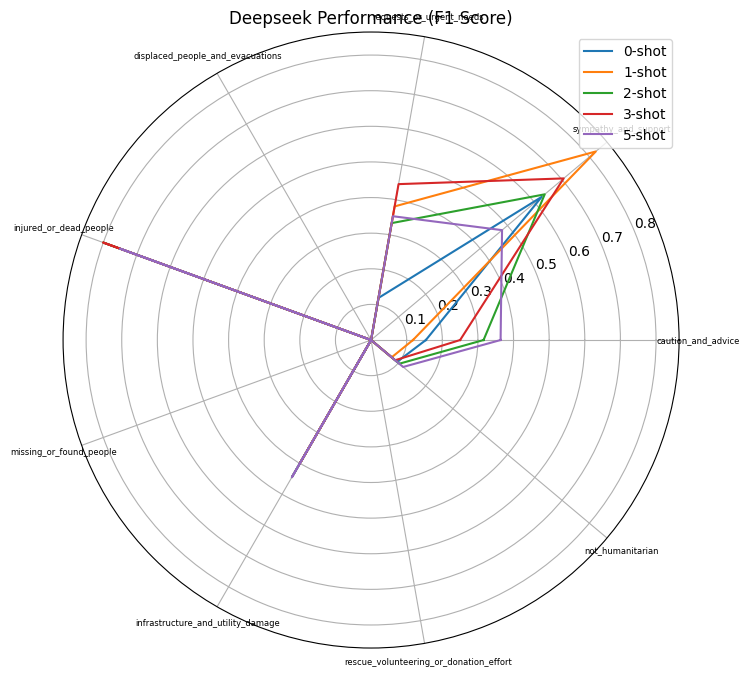

In [11]:
angles = np.linspace(0, 2 * np.pi, len(category_labels), endpoint=False)
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "polar"})

for num_shots, scores in f1_scores.items():
    ax.plot(np.concatenate((angles, [angles[0]])), np.concatenate((scores, [scores[0]])), label=f"{num_shots}-shot")

ticks = [round(max(scores), 2) for scores in f1_scores.values()]
ax.set_xticks(angles)
ax.set_xticklabels(category_labels, fontsize=6)
ax.set_title("Deepseek Performance (F1 Score)")
ax.legend()
plt.show()